## Terms for Use
Solvers are responsible for complying with all terms of use for the data sources they access.  All code in this document is provided using the [CC0 1.0 Universal (CC0 1.0) Public Domain Dedication](https://creativecommons.org/publicdomain/zero/1.0/).  The examples have been tested using Python 3 but have not been tested under Python 2.  Note that data providers may have changed their APIs or data formats after this notebook was published.

### Boring Details
The code cells below set up the notebook environment and load necessary libraries

In [1]:
%matplotlib inline

In [2]:
import matplotlib
matplotlib.style.use("seaborn-dark")
import os
import json
import re
from pprint import pprint
import numpy as np
import pandas as pd
from dateutil.parser import parse # To convert strings to timestamps
import warnings
import urllib3
http = urllib3.PoolManager()
GFC_HOME = os.path.abspath("../../..")
auth_file_path = os.path.join(GFC_HOME, "src", "resources", "auth.json")
with open(os.path.join(GFC_HOME, auth_file_path), "r") as f:
    api_key_dict = json.load(f)
data_path = os.path.join(GFC_HOME, "data")

## [eurostat](https://ec.europa.eu)

eurostat provides a great deal of statistical information about the countries of the European Union.  It provides a REST API which is documented at https://ec.europa.eu/eurostat/web/json-and-unicode-web-services/about-this-service.

### Example: Austrian Unemployment Data from eurostat
The example below will illustrate building a query, using `urllib3` to send the request, and processing the JSON return.  Each dataset has an identifier which can be found be browsing https://ec.europa.eu/eurostat/data/database.  For the unemployment data this is "teilm020".   The `geo` field is used to identify which countries are to be queried.  The best way to find those codes is to use their [query builder](https://ec.europa.eu/eurostat/web/json-and-unicode-web-services/getting-started/query-builder) and make a few selections to look at the resulting queries.  The code for Austria is "AT".  Putting it together:

In [3]:
EUROSTAT_URL_BASE = "http://ec.europa.eu/eurostat/wdds/rest/data/v2.1/json/en/"
DATASET_ID = "teilm020"
PRECISION_FILLER = "?precision=1"
GEO_ID = "AT"
query_url = EUROSTAT_URL_BASE + DATASET_ID + PRECISION_FILLER + "&geo={}".format(GEO_ID)
print("Our query URL is {}".format(query_url))
r = http.request("GET", query_url)
raw_data = r.data.decode()  # This produces a bytes object, we need to decode it to a string
print(raw_data)

Our query URL is http://ec.europa.eu/eurostat/wdds/rest/data/v2.1/json/en/teilm020?precision=1&geo=AT
{"version":"2.0","label":"Harmonised unemployment rate by sex","href":"http://ec.europa.eu/eurostat/wdds/rest/data/v2.1/json/en/teilm020?precision=1&geo=AT","source":"Eurostat","updated":"2019-04-02","status":{"11":":","23":":","35":":"},"extension":{"datasetId":"teilm020","lang":"EN","description":"The unemployment rate represents unemployed persons as a percentage of the labour force based on International Labour Office (ILO) definition. The labour force is the total number of people employed and unemployed. Unemployed persons comprise persons aged 15 to 74 who:<br />- are without work during the reference week; <br />- are available to start work within the next two weeks; <br />- and have been actively seeking work in the past four weeks or had already found a job to start within the next three months. <br />Data are presented in seasonally adjusted form.","subTitle":null,"status":

With the EIA data above we just used the `eval` command to turn the string into a dict.  Let's try it below....

In [4]:
try:
    eval(raw_data)
except NameError as e:
    print(repr(e))

NameError("name 'null' is not defined",)


That doesn't work.  The problem is a value of `null` for subTitle that isn't enclosed in quotes, so Python doesn't know what to do with it.  Let's try to fix it using a regex string substitution:

In [5]:
raw_data = re.sub("null", "\"null\"", raw_data)
_data = eval(raw_data)
pprint(_data)

{'class': 'dataset',
 'dimension': {'age': {'category': {'index': {'TOTAL': 0},
                                    'label': {'TOTAL': 'Total'}},
                       'label': 'age'},
               'geo': {'category': {'index': {'AT': 0},
                                    'label': {'AT': 'Austria'}},
                       'label': 'geo'},
               's_adj': {'category': {'index': {'SA': 0},
                                      'label': {'SA': 'Seasonally adjusted '
                                                      'data, not calendar '
                                                      'adjusted data'}},
                         'label': 's_adj'},
               'sex': {'category': {'index': {'F': 0, 'M': 1, 'T': 2},
                                    'label': {'F': 'Females',
                                              'M': 'Males',
                                              'T': 'Total'}},
                       'label': 'sex'},
               'time': {'categ

It's a bit confusing.  The elements of the `value` field look like the numbers that we want but there seem to be too many of them, considering that our time index only has 12 entries.  The reason for this can be found in the `category` field where we see that the data is broken out by females, males, and total.  Articulating the values to categories is non-intuitive.  I had to look at the [eurostat table layout for this data](https://ec.europa.eu/eurostat/data/database?p_p_id=NavTreeportletprod_WAR_NavTreeportletprod_INSTANCE_nPqeVbPXRmWQ&p_p_lifecycle=0&p_p_state=normal&p_p_mode=view&p_p_col_id=column-2&p_p_col_pos=1&p_p_col_count=2) in order to figure out which values correspond to which categories.  The values with indices 0 through 11 belong to the females, 12 through 23 to males, 24 to 35 for total.  Notice that there are no values given for indices 11, 23, or 35.  An inspection of the table layout shows that at the time I accessed the data the last month was missing.  OK, armed with this knowledge, let's try to make a data frame out of this data.  First, we need to convert the string formatted integer keys in the `value` field to actual integers:

In [6]:
_values = _data["value"]
_values = {int(k):v for k,v in _values.items()} # Keys are now integers

Now we need to insert "NA" values for missing elements.  To identify which items are missing we need to figure out how many we have.  That's the product of the number of categories and the length of the index.  Thankfully, the data has a `size` field that tells us the number of items along each dimension.  We just need to multiply so see how many we have:

In [7]:
dim = _data["size"]
prod = 1
for d in dim:
    prod = prod*d
print("There should be {} values.".format(prod))

There should be 36 values.


Lets put placeholders in our `_values` dict and convert to a pandas Series

In [8]:
for k in range(prod):
    if k not in _values.keys():
        _values[k] = np.nan
value_ser = pd.Series(_values)

We are going to create a tidy dataframe with variables in columns and each row representing a record.  Our dataframe will look something like:

    time    gender    value
0   2018M04    F        4.6

...

12  2018M04    M        4.9

...

34  2019M02    T        5.0

35  2019M03    T        NaN

The time column will just be the time index, repeated.  We'll grab the length of the time index for later use.

In [9]:
time_index = sorted(list(_data["dimension"]["time"]["category"]["index"].keys()))
n_periods = len(time_index)
time_index = 3*time_index
time_index_ser = pd.Series(time_index)

The Gender column will be 12 "F", 12 "M", 12 "T"  We could pull it out programmatically by parsing the fields and sorting them but it's easy enough to hard code:

In [10]:
genders = n_periods*["F"] + n_periods*["M"] + n_periods*["T"]
gender_ser = pd.Series(genders)

Putting it all together gives us this dataframe:

In [11]:
eurostat_df = pd.DataFrame({"month": time_index_ser,
                            "gender": gender_ser,
                            "value": value_ser})
eurostat_df.head()

,gender,month,value
0,F,2018M04,4.6
1,F,2018M05,4.5
2,F,2018M06,4.5
3,F,2018M07,4.8
4,F,2018M08,5.1


Suppose that we want to plot the trend in total unemployment.  We could parse the month column to get timestamps but we can see what we want without doing so:

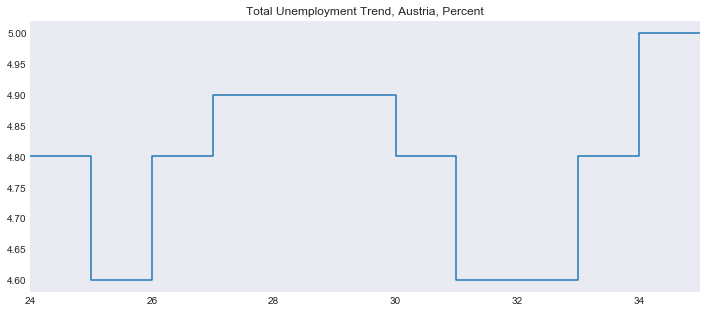

In [12]:
total_df = eurostat_df[eurostat_df.gender=="T"]
total_df["value"].plot(title="Total Unemployment Trend, Austria, Percent",
                       figsize=(12,5), drawstyle="steps-post");